In [20]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
X, y = load_breast_cancer(return_X_y=True)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X = StandardScaler().fit_transform(X)
print(X.shape)

(569, 30)


In [4]:
from sklearn.model_selection import StratifiedKFold

In [5]:
sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-2, 2e-1, 5e-1, 7e-1, 1, 1.5, 2, 3, 5, 10, 20, 40, 2e3, 2e5]
print(sigmas)
accuracies = []
all_grads = []

for s in sigmas:
    accs = []
    skf = StratifiedKFold(n_splits=5)
    print(f"testing for sigma = {s}")
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\t running fold {i + 1}", end='')
        clf = SVM_smooth(sigma=s, lbd=1e-35)
        lr = 0.85/n
        clf.fit(X[train_idx], y[train_idx], thresh=1e-3, n_iter=5500, eta=lr, approx_cv=False, cv=False, save_grads=True)
        
        y_pred = clf.predict(X[test_idx])
        print(f" : acc {accuracy_score(y[test_idx], y_pred)}")
        accs.append(accuracy_score(y[test_idx], y_pred))

    accuracies.append(accs)
    print(f"mean CV accuracy is {np.mean(accs)}")
    all_grads.append(np.linalg.norm(clf.grads_, axis=1))

[2e-15, 2e-10, 2e-05, 0.002, 0.02, 0.2, 0.5, 0.7, 1, 1.5, 2, 3, 5, 10, 20, 40, 2000.0, 200000.0]
testing for sigma = 2e-15
	 running fold 0 : acc 0.9824561403508771
	 running fold 1 : acc 0.9736842105263158
	 running fold 2 : acc 0.9912280701754386
	 running fold 3 : acc 0.9736842105263158
	 running fold 4 : acc 0.9911504424778761
mean CV accuracy is 0.9824406148113647
testing for sigma = 2e-10
	 running fold 0 : acc 0.9824561403508771
	 running fold 1 : acc 0.9736842105263158
	 running fold 2 : acc 0.9912280701754386
	 running fold 3 : acc 0.9736842105263158
	 running fold 4 : acc 0.9911504424778761
mean CV accuracy is 0.9824406148113647
testing for sigma = 2e-05
	 running fold 0 : acc 0.9824561403508771
	 running fold 1 : acc 0.9736842105263158
	 running fold 2 : acc 0.9912280701754386
	 running fold 3 : acc 0.9736842105263158
	 running fold 4 : acc 0.9911504424778761
mean CV accuracy is 0.9824406148113647
testing for sigma = 0.002
	 running fold 0 : acc 0.9824561403508771
	 running 

In [6]:
means = []
for a in accuracies:
    means.append(np.mean(a))

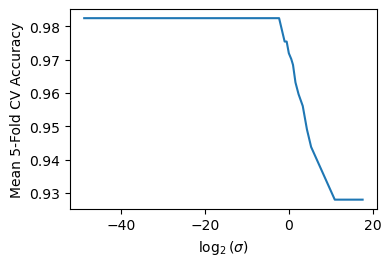

In [7]:
fig, ax = plt.subplots()
ax.plot(np.log2(sigmas), means)
ax.set_xlabel("$\log_2(\sigma)$")
ax.set_ylabel("Mean 5-Fold CV Accuracy")

ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svmtest_sigma_accuracy.pgf', bbox_inches='tight', pad_inches=0)

In [21]:
fig, axs = plt.subplots(5, 3, figsize=(6, 7))

for i, ax in enumerate(axs.flat):
    ax.plot(all_grads[i])
    ax.set_title(f"$\sigma$={sigmas[i]}")

plt.tight_layout()
ws = 1.15 # 1.75
hs = 0.55 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
plt.savefig('svmtest_sigma_grads.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_15070/3094595528.py:12: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
